In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import os

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
raw_data = pd.read_csv('data/df_result.csv')
raw_data.set_index('date', inplace=True)
raw_data.sort_index(inplace=True)

raw_data.head()

,start_region,trips_count
date,,
2015-01-01 00:00:00,1252,0
2015-01-01 00:00:00,1672,0
2015-01-01 00:00:00,1673,0
2015-01-01 00:00:00,1674,0
2015-01-01 00:00:00,1675,1


In [11]:
# данные хранились в двух столбцах, развернем в сводную таблицу по ячейкам
raw_data2 = pd.pivot_table(raw_data, index='date', columns='start_region', values='trips_count', aggfunc=sum)
raw_data2.head()

start_region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Отберем данные за май для ячеек со средним количеством поездок больше 5
data_may = raw_data2.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00', :]
(data_may.mean()>5).sum()

102

In [14]:
# список интересующих ячеек
r_list = data_may.loc[:, data_may.mean()>5].columns

In [15]:
filtered_data = raw_data2.loc['2016-01-01 00:00:00':'2016-04-30 23:00:00', r_list]
filtered_data.head(2)

start_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66
2016-01-01 01:00:00,91,211,49,134,404,420,370,453,594,224,...,29,0,5,2,2,4,0,47,1,29


In [16]:
# Стандартизируем ряд

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(filtered_data), 
                       columns = filtered_data.columns, index =filtered_data.index)
data.head()

start_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.534333,0.178299,-0.565388,0.271055,1.423610,0.941333,1.327688,1.324958,1.906912,1.834977,...,1.551231,-0.883705,-0.571914,-1.047780,-1.251905,-0.786766,-0.681902,-0.821275,-0.855714,0.031380
2016-01-01 01:00:00,0.823393,1.005639,-0.582598,1.673853,2.292927,1.069294,0.407607,0.529828,0.846918,1.255230,...,5.252950,-0.883705,-0.069239,-1.325716,-1.275832,-1.423829,-1.172000,-1.125258,-1.089383,-0.931147
2016-01-01 02:00:00,0.797115,0.202995,-1.030077,1.083201,2.180427,1.104839,0.081865,0.108021,-0.065856,0.095738,...,9.172418,-0.883705,-0.404356,-1.338951,-1.259881,-1.492701,-1.172000,-0.834492,-1.089383,-1.321360
2016-01-01 03:00:00,-0.727022,-0.525558,-1.150552,-0.098103,0.738384,0.920006,0.144727,-0.168335,-0.276172,0.473247,...,8.954670,-0.883705,-0.571914,-1.312481,-1.251905,-1.475483,-1.172000,-1.468890,-1.128328,-1.451432
2016-01-01 04:00:00,-0.937247,-1.068886,-1.253817,-0.319598,-0.355932,-0.110791,-0.198160,-0.051975,-0.314029,0.190115,...,8.301425,-0.883705,-0.907031,-1.332334,-1.283807,-1.492701,-1.172000,-1.402807,-1.089383,-1.529474


In [17]:
data.index = pd.to_datetime(data.index)

In [10]:
# Рассмотрим несколько алгоритмов кластеризации

# * K-mean (Mini Batch K-mean)
# * Affinity Propagation Clustering
# * Aglomerative Clustering

# Выберем оптимальное число кластеров с помощью силуэтного анализа

In [11]:
def plot_silhouette(method, data, n_clusters):
    res = method.fit_predict(data)
    sil = silhouette_samples(data, res)
    silhouette_avg = silhouette_score(data, res)
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)

    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[res == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        spectral_color = cm.get_cmap("Spectral")
        color = spectral_color(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

In [12]:
def optimal_clusters_division(method, data, max_n_clusters, print_answer = False):
    score_list = []
    for n_clusters in range(2, max_n_clusters+1):
        res = method(n_clusters = n_clusters).fit_predict(data)
        score = silhouette_score(data, res)
        score_list.append(score)
    if print_answer == True:            
        print('Максимальный коэффициент силуэта равен {}. Достигнут при числе кластеров равном {}'\
        .format(max(score_list), score_list.index(max(score_list))+2))
        return 
    return score_list  

In [13]:
# K-means

max_n_clusters = 10

In [14]:
optimal_clusters_division(KMeans, data.T, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.25695202854235594. Достигнут при числе кластеров равном 2


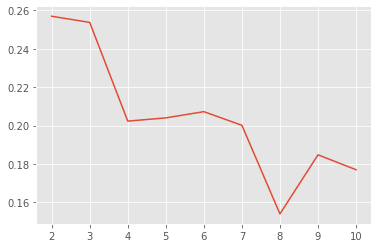

In [15]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(KMeans, data.T, max_n_clusters))

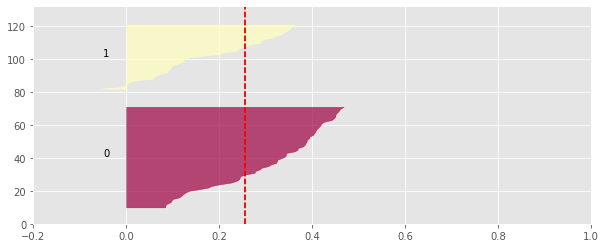

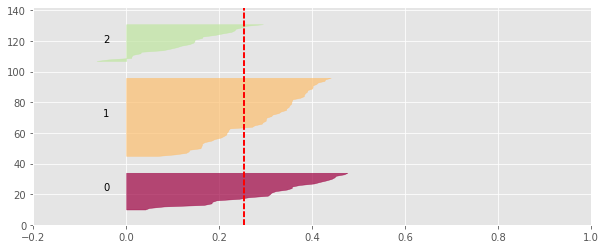

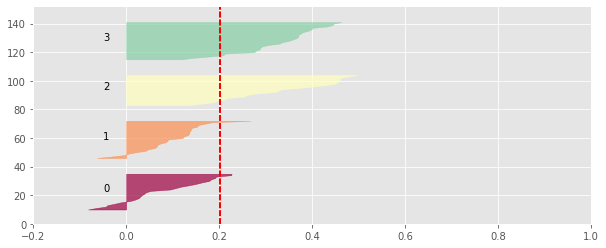

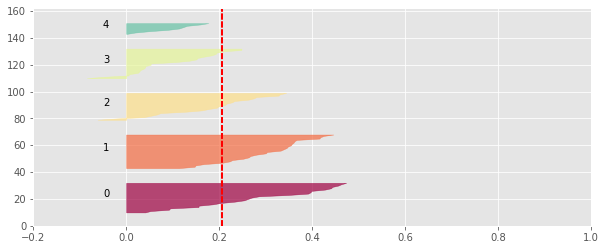

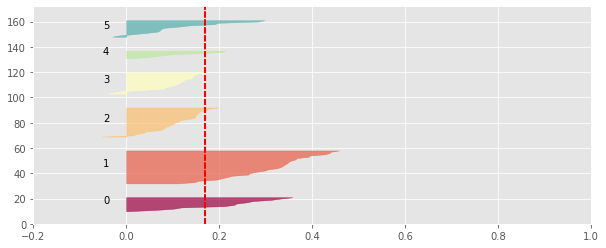

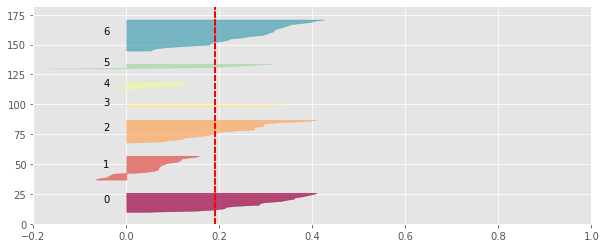

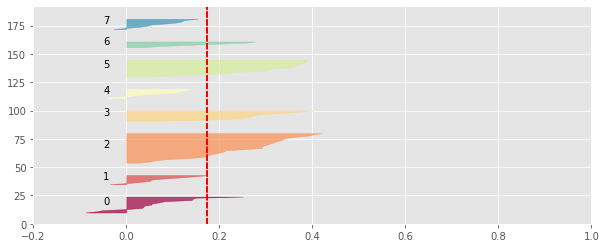

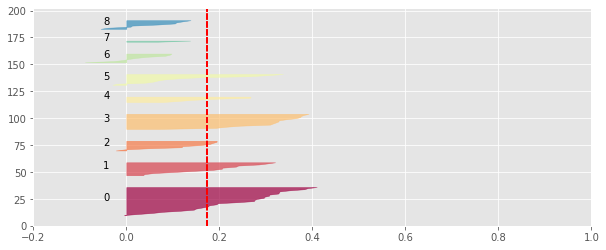

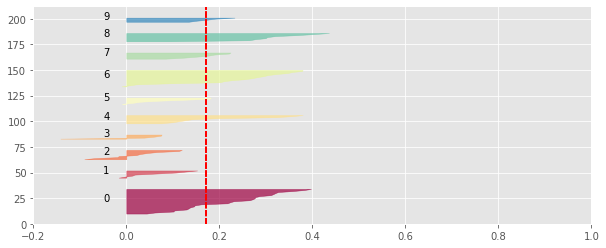

In [16]:
for n_clusters in range(2, max_n_clusters+1):
    plot_silhouette(KMeans(n_clusters=n_clusters), data.T, n_clusters)

In [17]:
# Вывод - нужно ориентироватся на количество кластеров в районе 4-5

In [18]:
# *Affinity Propagation Clustering*

In [19]:
score_list = []
number_of_clusters_list=[]
for damp in np.linspace(0.51, 0.99, num=9):
    clustering = AffinityPropagation(damping = damp).fit_predict(data.T)
    score = silhouette_score(data.T, clustering)
    score_list.append(score)
    n_clusters = np.unique(clustering).size
    number_of_clusters_list.append(n_clusters)
    print('Коэффициент силуэта:{} число кластеров:{}'.format(score, n_clusters))

Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18577401939234486 число кластеров:10
Коэффициент силуэта:0.18685764666476687 число кластеров:11
Коэффициент силуэта:0.21444770570579927 число кластеров:2


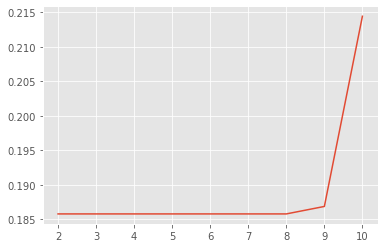

In [20]:
plt.plot(np.arange(2, max_n_clusters+1), score_list)

In [21]:
cluster_model = AffinityPropagation(damping = 0.6)
res = cluster_model.fit_predict(data.T)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 5, 15,  9, 17, 27, 12,  4,  4,  4,  5], dtype=int64))

In [22]:
# *Aglomerative Clustering*

In [23]:
optimal_clusters_division(AgglomerativeClustering, data.T, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.2390414329133946. Достигнут при числе кластеров равном 3


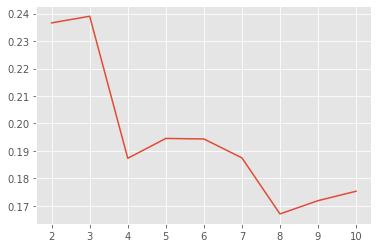

In [24]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(AgglomerativeClustering, data.T, max_n_clusters))

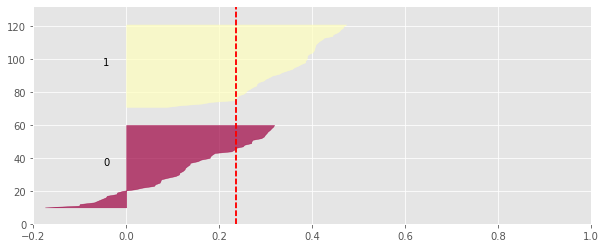

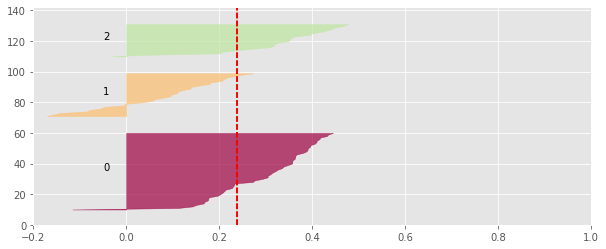

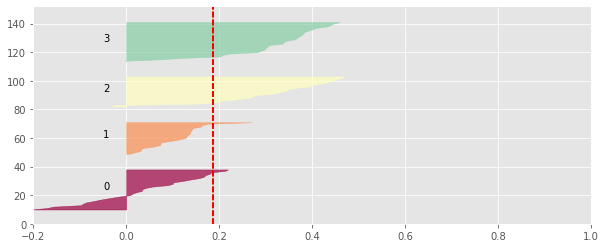

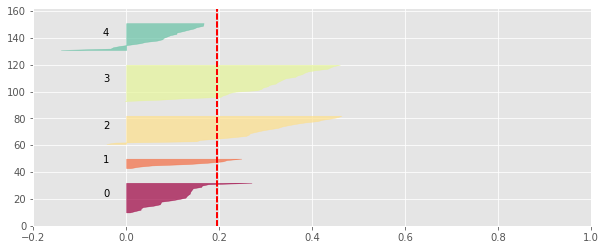

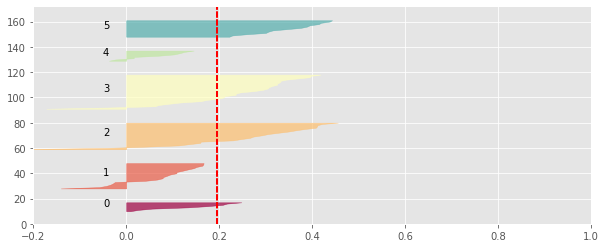

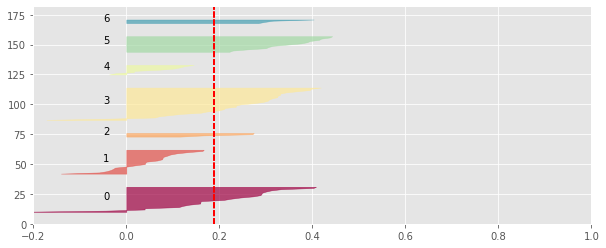

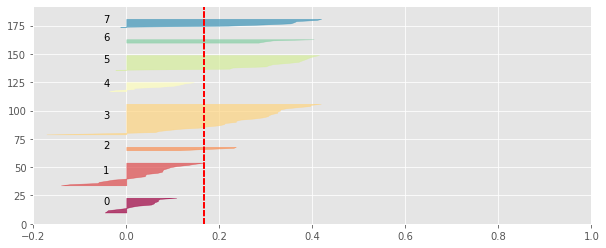

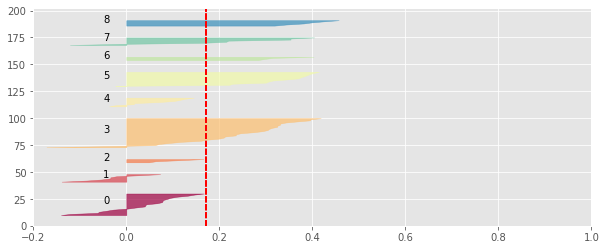

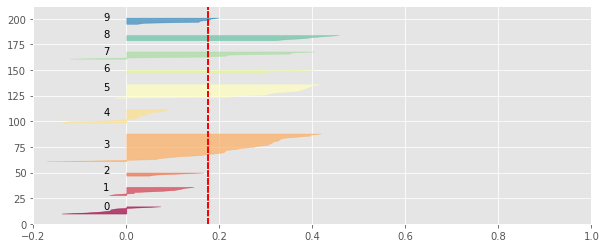

In [25]:
for n_clusters in range(2, max_n_clusters+1):
    plot_silhouette(AgglomerativeClustering(n_clusters=n_clusters), data.T, n_clusters)

In [26]:
# Выбираем кластеризацию методом K-means с разбиением на 4 кластера

In [27]:
cluster_model = KMeans(n_clusters = 4, random_state = 42)
res = cluster_model.fit_predict(data.T)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3]), array([22, 27, 27, 26], dtype=int64))

In [28]:
clusters_numbers = np.unique(res)
print ('Номера кластеров: ', clusters_numbers)

Номера кластеров:  [0 1 2 3]


In [29]:
id_in_clusters_dict = {key: data.T[res==key].index for key in clusters_numbers}

In [30]:
for key in clusters_numbers:
    print ('id зон кластера номер', key)
    print (id_in_clusters_dict.get(key))

id зон кластера номер 0
Int64Index([1129, 1130, 1176, 1177, 1178, 1221, 1222, 1223, 1227, 1228, 1272,
            1273, 1274, 1326, 1327, 1376, 1377, 1378, 1380, 1426, 1532, 1533],
           dtype='int64', name='start_region')
id зон кластера номер 1
Int64Index([1076, 1077, 1132, 1181, 1183, 1184, 1234, 1235, 1279, 1280, 1283,
            1284, 1285, 1286, 1287, 1331, 1332, 1333, 1334, 1335, 1336, 1337,
            1383, 1384, 1385, 1386, 1434],
           dtype='int64', name='start_region')
id зон кластера номер 2
Int64Index([1075, 1125, 1126, 1127, 1128, 1131, 1179, 1180, 1229, 1230, 1231,
            1232, 1233, 1281, 1282, 1338, 1339, 1382, 1684, 1733, 1734, 1783,
            2068, 2069, 2118, 2119, 2168],
           dtype='int64', name='start_region')
id зон кластера номер 3
Int64Index([1172, 1173, 1174, 1175, 1182, 1224, 1225, 1278, 1387, 1388, 1389,
            1390, 1431, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482,
            1483, 1530, 1580, 1630],
           dtyp

In [31]:
def plot_cluster_data(length, cluster_key):
    print ('Длина выводимого ряда: {}, номер кластера: {}'.format(length, cluster_key))
    plt.figure(figsize=(20,10))
    for id in id_in_clusters_dict.get(cluster_key):
#         plt.plot(range(100), data[cur_column].iloc[-100:])
        data.loc[:, id][:length].plot()
    plt.show()

Длина выводимого ряда: 200, номер кластера: 0


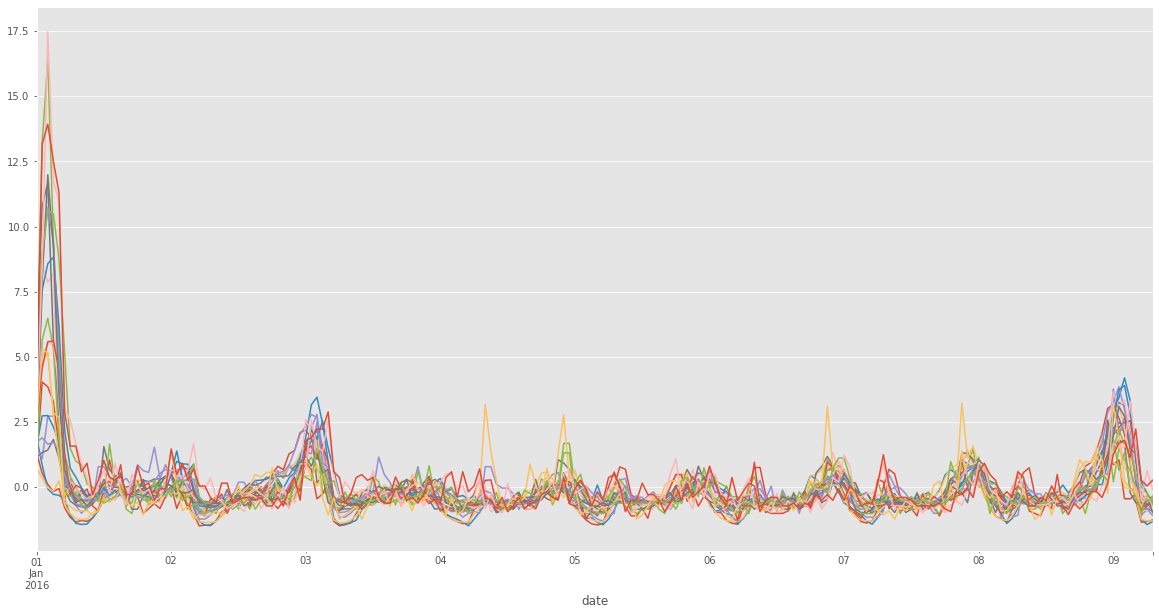

Длина выводимого ряда: 200, номер кластера: 1


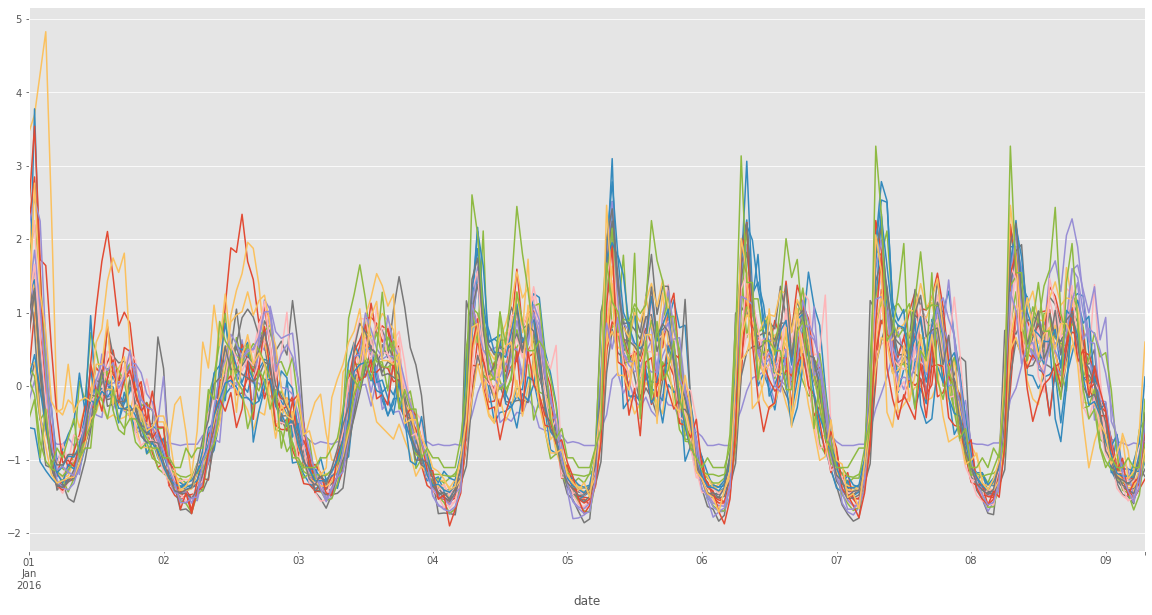

Длина выводимого ряда: 200, номер кластера: 2


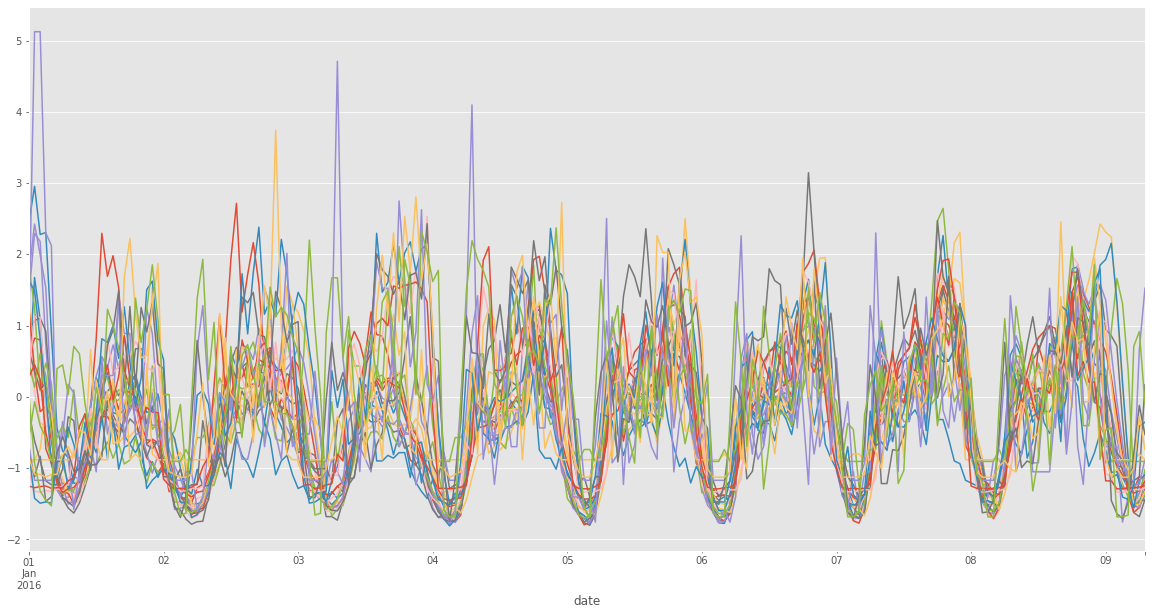

Длина выводимого ряда: 200, номер кластера: 3


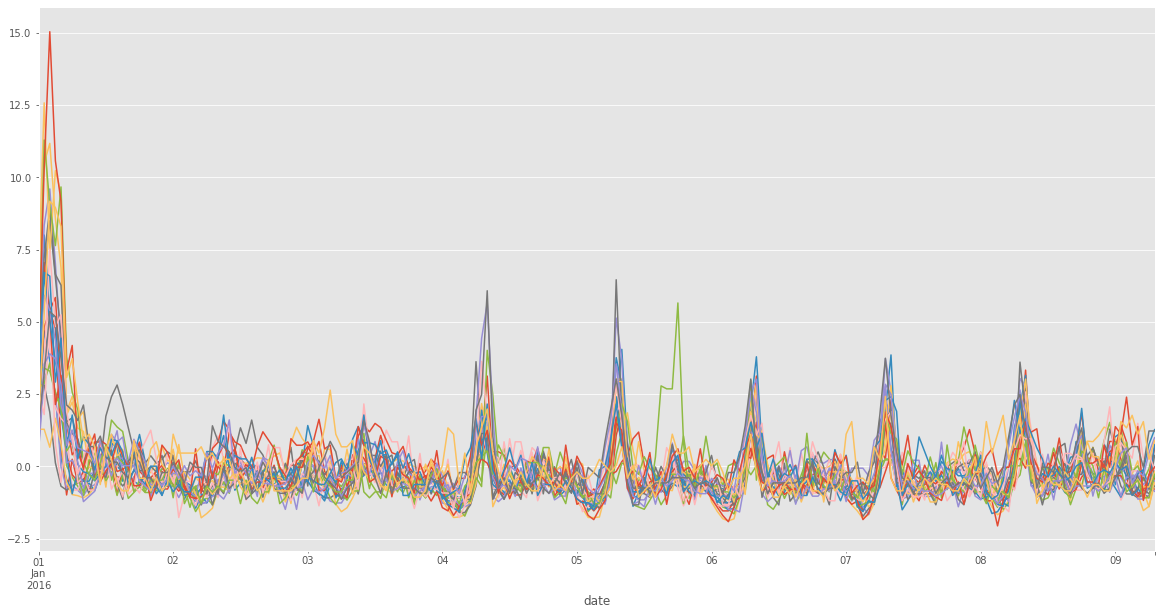

In [32]:
plot_length = 200
for key in clusters_numbers:
    plot_cluster_data(plot_length, key)

In [33]:
# Определим центр для каждого кластера. Найдем среднее значение и наиболее коррелирующую ему строку временного ряда

In [34]:
def find_center(cluster_number):
    pearson_list = []
    cluster_mean = data.T[res == cluster_number].mean(axis = 0)
    for index, row in data.T[res == cluster_number].iterrows():
        pearson_list.append(pearsonr(cluster_mean, row)[0])
    return pearson_list.index(max(pearson_list)) 

In [35]:
center_dict = {number:data.T[res == number].iloc[find_center(number), :] for number in clusters_numbers}

In [36]:
for key in clusters_numbers:
    print ('Номер кластера: {}, id центра кластера: {}'.format(key, center_dict.get(key).name))

Номер кластера: 0, id центра кластера: 1326
Номер кластера: 1, id центра кластера: 1333
Номер кластера: 2, id центра кластера: 1233
Номер кластера: 3, id центра кластера: 1387


In [37]:
id_centers_names = [center_dict.get(key).name for key in clusters_numbers]
print ('Лист с id центральных кластеров:', id_centers_names)

Лист с id центральных кластеров: [1326, 1333, 1233, 1387]


In [38]:
# Для экономии ресуров и времени было принято решение отказаться от использования модели SARIMAX. Предсказание будет вестись в два этапа. Сначала будет построена модель прогнозов на основе регрусионных признаков от ряда Фурье. После этого по остаткам регресии будет расчитана модель SARIMA. результатом прогноза будет сумма значений двух моделей.

**Подбор параметров для линейной регрессии**

In [40]:
def plot_K(key, data):
    mse_list = []
    K = 25
    for number in range (1, K+1):
        ols_data = pd.DataFrame(data.copy())
        for i in range(1, number+1):        
            ols_data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
            ols_data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        y = ols_data.iloc[:, 0]
        X = ols_data.loc[:, 's_1':]
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
        K_opt = np.argmin(mse_list)
#     print 'Минимальное квадратичное отклонение достигнуто при K =', K_opt    
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(1, K+1), mse_list, 'ro')
    plt.title(u'Зависимость между гиперпараметром K и средней квадратичной ошибкой для кластера ' + str(key))
    plt.xlabel(u'К')
    plt.ylabel(u'Mean square error')

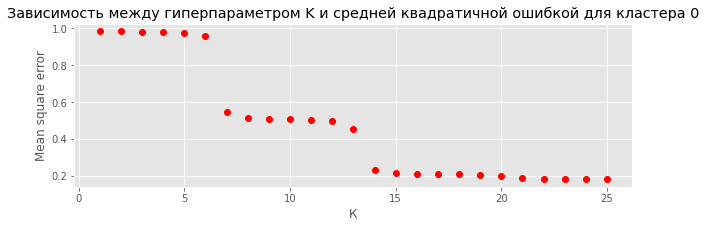

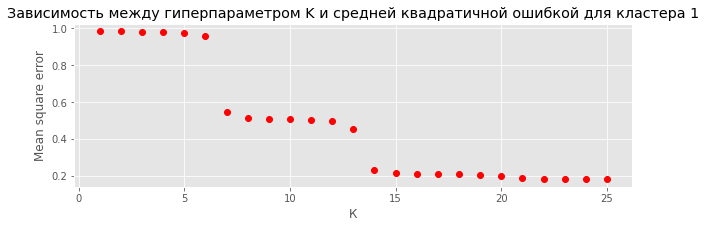

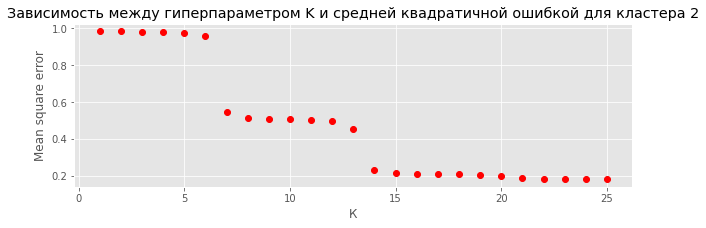

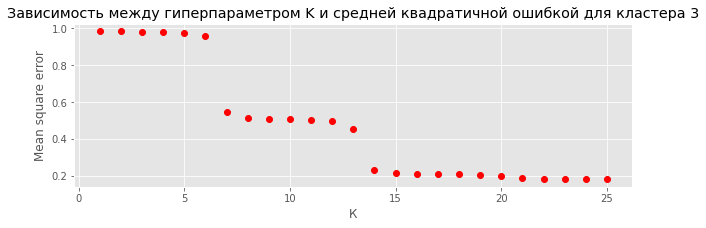

In [42]:
for key in clusters_numbers:
    plot_K(key, data[1332])

In [43]:
K_opt = 15

In [44]:
# Создадим наборы признаков для каждого центрального ряда кластеров

In [45]:
def get_fourier_df_and_LR_model(key, K, df):
    '''
    Функция возвращает: 
    1) датафрейм с набором исходных значений, набором регрессионных признаков, предсказанием линейной модели,
    остаток 
    2) обученную модель линейного регрессора.
    '''
    series = pd.DataFrame.copy(df)[id_centers_names[key]]
    df_f = pd.DataFrame(series)
    for i in range(1, K+1):        
            df_f['s_'+str(i)] = np.sin(np.arange(1, len(series)+1)*2*np.pi*i/168)
            df_f['c_'+str(i)] = np.cos(np.arange(1, len(series)+1)*2*np.pi*i/168)
    y = df_f.iloc[:,0]
    X_opt = df_f.iloc[:, 1:]
    
    model = LinearRegression()
    res = model.fit(X_opt, y)
    y_pred = res.predict(X_opt)

    df_f['l_prediction'] = y_pred
    df_f['remain'] = y - y_pred 
    return df_f, res

In [46]:
fourier_and_LM_dict = {key: get_fourier_df_and_LR_model(key, K = K_opt, df = data) for key in clusters_numbers}

In [47]:
fourier_and_LM_dict.get(1)[0].head(2)

,1333,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_12,c_12,s_13,c_13,s_14,c_14,s_15,c_15,l_prediction,remain
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1.000432,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.433884,0.900969,0.467269,0.884115,0.500000,0.866025,0.532032,0.846724,-1.067171,2.067603
2016-01-01 01:00:00,1.331004,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,0.781831,0.623490,0.826239,0.563320,0.866025,0.500000,0.900969,0.433884,-1.405608,2.736612


In [48]:
# **Подбор параметров для SARIMA модели**

In [49]:
def diff_and_plot_STL_dec(key, print_STL = True):
    '''
    Функция возвращает:
    датафрейм временного ряда с добавленнием дифференцирования
    выводит STL декомпозицию при print_STL = True
    '''
    print('Номер кластера: ', key)
    df = pd.DataFrame.copy(fourier_and_LM_dict.get(key)[0])
    #недельное дифференциирование
    df['remain_diff168'] = df['remain'] - df['remain'].shift(168)
    #суточное дифференциирование
    df['remain_diff168_24'] = df['remain_diff168'] - df['remain_diff168'].shift(24)
    # стандартное дифференциирование
    df['remain_diff168_24_1'] = df['remain_diff168_24'] - df['remain_diff168_24'].shift(1)
    if print_STL:
        plt.figure(figsize=(15,8))
        sm.tsa.seasonal_decompose(df['remain_diff168_24_1'][193:], freq = 24).plot()
        plt.show()
        print('Значение критерия Дики-Фуллера для ряда:', sm.tsa.stattools.adfuller(df['remain_diff168_24_1'][193:])[1])
    return df

Номер кластера:  0


<Figure size 1080x576 with 0 Axes>

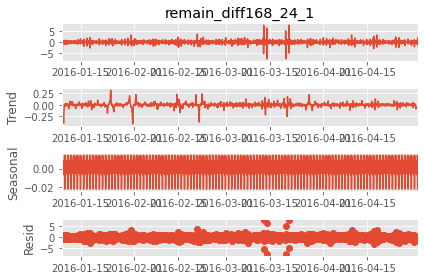

Значение критерия Дики-Фуллера для ряда: 5.6988689954320875e-28
Номер кластера:  1


<Figure size 1080x576 with 0 Axes>

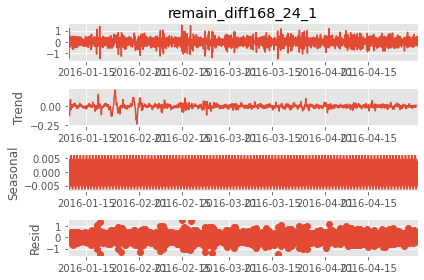

Значение критерия Дики-Фуллера для ряда: 3.0660620450327292e-28
Номер кластера:  2


<Figure size 1080x576 with 0 Axes>

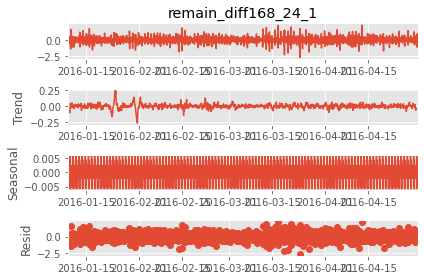

Значение критерия Дики-Фуллера для ряда: 2.4667263507634095e-28
Номер кластера:  3


<Figure size 1080x576 with 0 Axes>

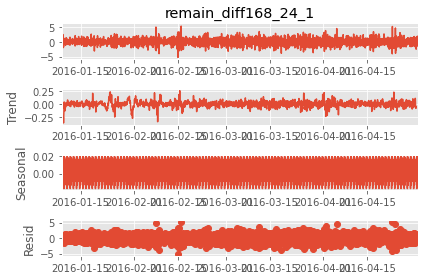

Значение критерия Дики-Фуллера для ряда: 7.597567678737706e-28


In [50]:
LR_model_and_diff_dict = {key:diff_and_plot_STL_dec(key) for key in clusters_numbers}

In [51]:
# Значения критерия Дики - Фуллера позволяют уверенно отвергнуть гипотезу о нестационарности нашей модели. Визуальный анализ так же подтвержает это. Считаем продиференцированые ряды остатков стационарными.

In [53]:
# Подберем коэффициенты SARIMA модели с помощью анализа графиков полной и частичной автокорреляции данных. Возьмем лаг чуть больший длины самого большого сезонного периода - недели (168).

In [52]:
def plot_autocorr_plots(key):
    print ('Номер кластера:', key)
    series = LR_model_and_diff_dict.get(key)['remain_diff168_24_1'][193:]
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(series, lags = 180, ax = ax)
    plt.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(series, lags = 180, ax = ax)
    plt.show()

Номер кластера: 0


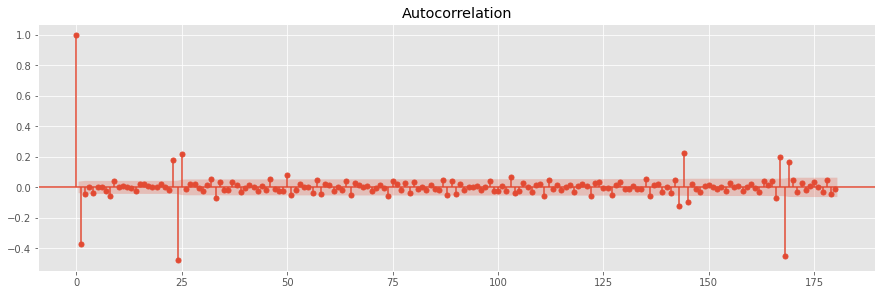

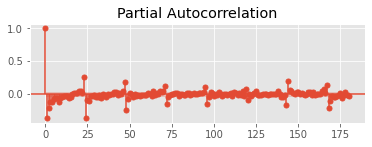

Номер кластера: 1


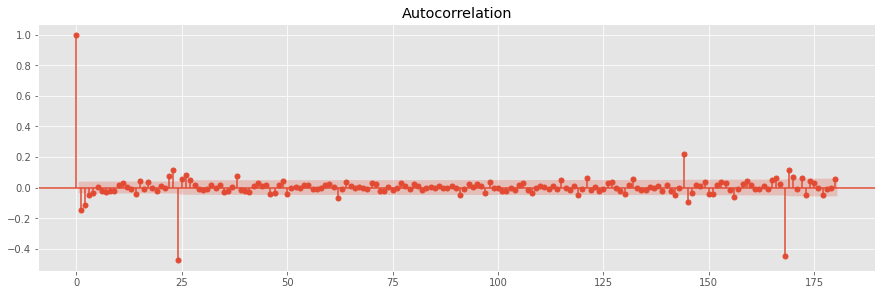

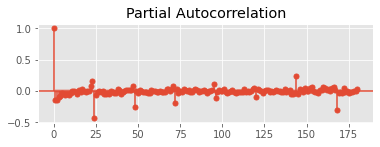

Номер кластера: 2


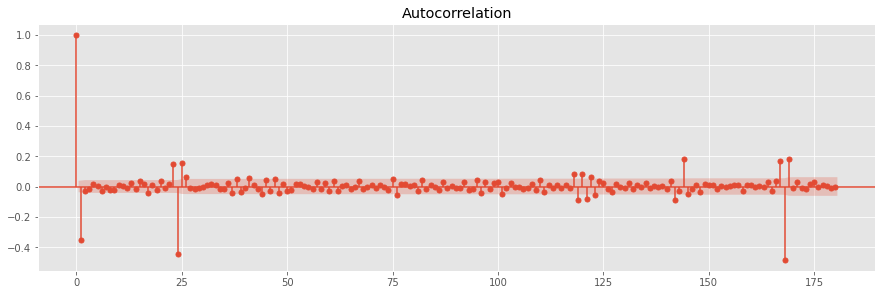

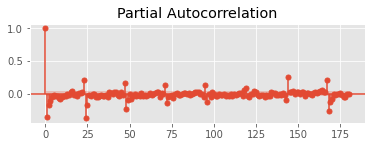

Номер кластера: 3


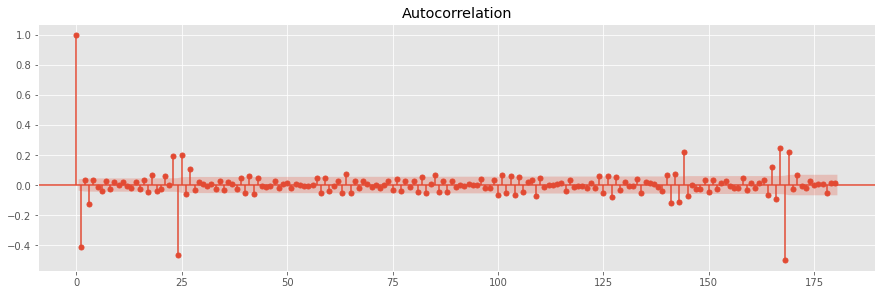

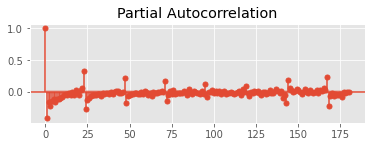

In [54]:
for key in clusters_numbers:
    plot_autocorr_plots(key)

In [55]:
# Выбранные значения параметров:
# * Q = 1
# * q = 2
# * P = 1
# * p = 2

In [56]:
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 2) 
D = 1 # при двойном сезонном дифференцировании резульаты были хуже, а время на вычисления удваивалось
Qs = range(0, 2)

In [57]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [58]:
def build_ARIMAX(key, series):    
#     df = fourier_dict.get(key)[0]
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore') #отключим предупрежедения, так как не все модели, которые мы получим в процессе перебора, 
                                      #будут сходящимися
    for param in parameters_list:     
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(series, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue

        except np.linalg.LinAlgError:
            print('singularity parameters:', param)
            continue

        aic = model.aic
#         print 'parameters:{} have aic value {}'.format(param, aic)
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    return result_table.sort_values(by = 'aic', ascending=True), best_model

In [59]:
%%time
ARIMA_dict = {key:build_ARIMAX(key, series = LR_model_and_diff_dict.get(key)['remain']) for key in clusters_numbers}

Wall time: 38min 30s


In [60]:
ARIMA_dict

{0: (      parameters          aic
  31  (2, 1, 1, 1)  2412.327947
  23  (1, 2, 1, 1)  2413.172944
  19  (1, 1, 1, 1)  2416.047102
  35  (2, 2, 1, 1)  2416.764570
  29  (2, 1, 0, 1)  2430.058096
  21  (1, 2, 0, 1)  2431.652456
  33  (2, 2, 0, 1)  2437.088091
  17  (1, 1, 0, 1)  2437.351873
  11  (0, 2, 1, 1)  2616.920186
  9   (0, 2, 0, 1)  2632.628565
  27  (2, 0, 1, 1)  2857.865728
  7   (0, 1, 1, 1)  2875.262367
  25  (2, 0, 0, 1)  2888.594462
  15  (1, 0, 1, 1)  2908.005035
  5   (0, 1, 0, 1)  2912.520216
  13  (1, 0, 0, 1)  2941.489191
  3   (0, 0, 1, 1)  2975.228356
  1   (0, 0, 0, 1)  2999.527673
  34  (2, 2, 1, 0)  3435.309441
  30  (2, 1, 1, 0)  3465.119867
  22  (1, 2, 1, 0)  3466.999480
  18  (1, 1, 1, 0)  3474.714859
  10  (0, 2, 1, 0)  3667.782470
  32  (2, 2, 0, 0)  3907.797679
  26  (2, 0, 1, 0)  3934.252680
  6   (0, 1, 1, 0)  3956.860269
  16  (1, 1, 0, 0)  3964.430470
  28  (2, 1, 0, 0)  3965.997276
  20  (1, 2, 0, 0)  3966.052755
  14  (1, 0, 1, 0)  3986.447693
  2  

In [62]:
def evaluate_sarima_aproximation(key):
    arima_series = ARIMA_dict.get(key)[1].fittedvalues
    lm_series = LR_model_and_diff_dict.get(key)['l_prediction']
    forecast = arima_series + lm_series
    real_data = LR_model_and_diff_dict.get(key).iloc[:, 0]
    print('r2_score для кластера {}: {}'.format(key, r2_score(forecast, real_data)))
    
    plt.figure(figsize=(20, 5))
    plt.plot(forecast[2500:3000], label = 'Linear model + SARIMA')
    plt.plot(lm_series[2500:3000], label = 'Linear model')
    plt.plot(real_data[2500:3000], label = 'Real data', color = 'green', alpha = 0.5)
    
    plt.legend()
    plt.show()  

r2_score для кластера 0: 0.839181726682463


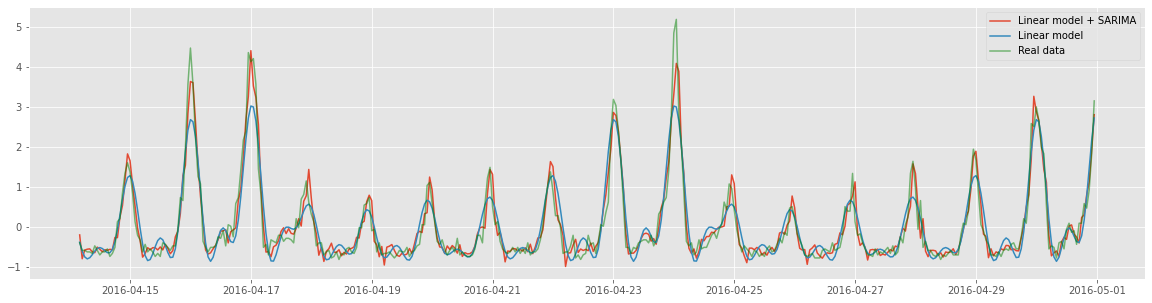

r2_score для кластера 1: 0.9434901126355041


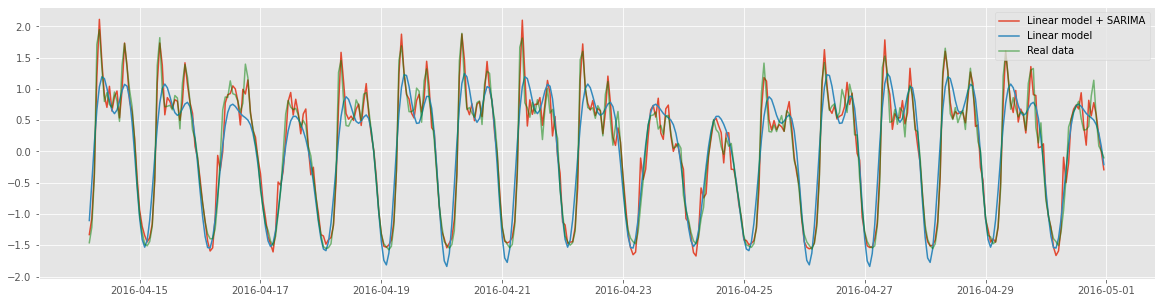

r2_score для кластера 2: 0.9305046053190025


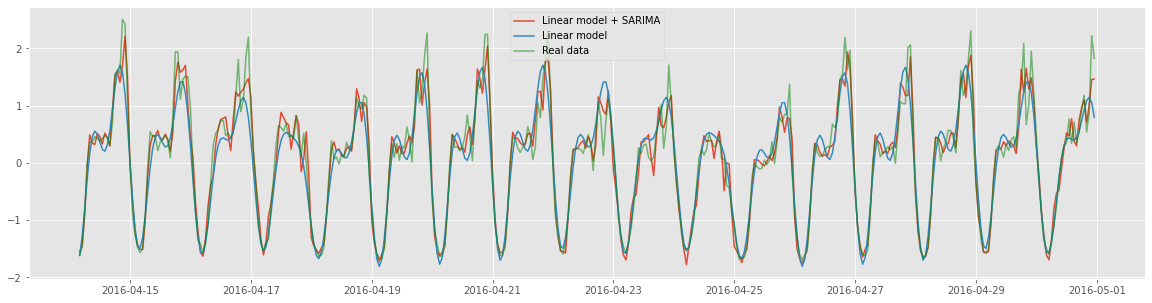

r2_score для кластера 3: 0.5761567198954887


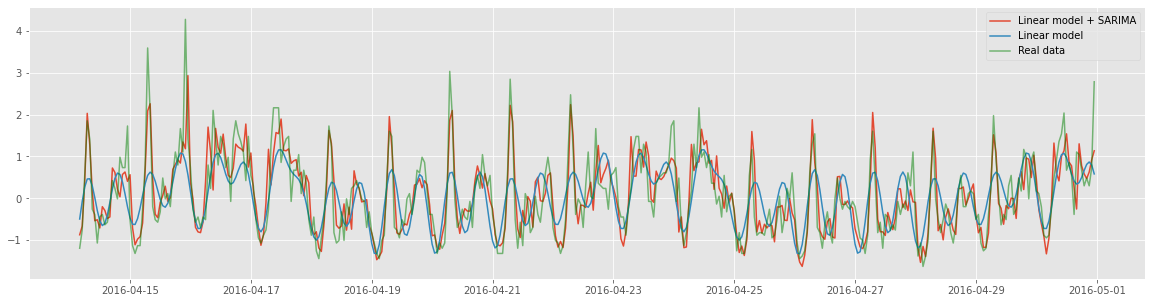

In [63]:
for key in clusters_numbers:
    evaluate_sarima_aproximation(key)

In [64]:
# изуальная оценка вкупе с коэффициентом детерминации дают приемлимые результаты.
# Далее будем использовать наборы оптимальных параметров для обучения и прогнозирования LR и SARIMA моделей на реальных данных

In [65]:
best_ARIMA_params_list = []
for key in clusters_numbers:
    best_ARIMA_params_list.append(ARIMA_dict.get(key)[0].iloc[0].values[0])
print(best_ARIMA_params_list)

[(2, 1, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1)]


In [66]:
#   **Прогнозирование времнных рядов**
# **Прогнозирование в интервале от 2016.04.30 23:00 до 2016.05.31 17:00 на 6 часов вперед**

In [18]:
data_may = raw_data2.loc[:'2016-05-31 23:00:00']

In [23]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [19]:
def prepare_data(key, id_number, data, split_date, K):
    data =data.copy()[id_number].to_frame()
    data.columns = ['y']
    data.index = pd.to_datetime(data.index)
    
    split_number = len(data.loc[:split_date, :])
    
    
    # добавляем набор регрессионных признаков Фурье
    for i in range(1, K+1):        
            data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
            data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:split_number], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:split_number], 'hour', "y").get, data.hour))
    
    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:split_number].drop(["y"], axis=1)
    y_train = data.loc[:split_number]["y"]
    X_test = data.loc[split_number:].drop(["y"], axis=1)
    y_test = data.loc[split_number:]["y"]

    return X_train, X_test, y_train, y_test

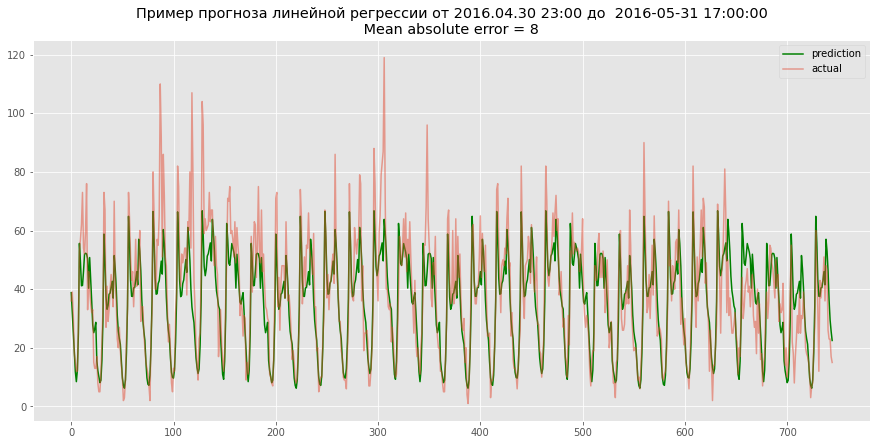

In [72]:
X_train, X_test, y_train, y_test = prepare_data(key = 0, id_number = 1386, data = data_may, 
                                                split_date = '2016-04-30 22:00:00', K = K_opt)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction")
plt.plot(y_test.values, label="actual", alpha = 0.5)
plt.legend(loc="best")
plt.title(u"Пример прогноза линейной регрессии от 2016.04.30 23:00 до  2016-05-31 17:00:00\n Mean absolute error = {} "\
          .format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [73]:
# Визуальный анализ и метрика подтверждает правильность работы функции.

In [74]:
# Подготовим остатки линейной регресии для каждого ряда и обучим для него SARIMA модель. Если SARIMA модель не запуститься, то применяем ARMA модель.

In [75]:
best_ARIMA_params_list

[(2, 1, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1)]

In [76]:
def generate_SARIMA_models(key, id_number, data, split_date, folder_name, K):
    X_train, _, y_train, _ = prepare_data(key = key, id_number = id_number, data = data, 
                                                    split_date = split_date, K = K)
    # Подгтовка LR модели для каждого ряда
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    remains = lr.predict(X_train) - y_train
    
    try:
        # Пробуем SARIMA модель 
        param = best_ARIMA_params_list[key]
        model=sm.tsa.statespace.SARIMAX(remains, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)         
        model.save('data/SARIMA_models/' + str(folder_name)+ '/SARIMA model ' + str(id_number) + '.pkl')
        del model
        print(id_number,)            

    except:
        print()
        print('Ошибка при построении SARIMA модели')

        try:
            # Пробуем ARMA модель
            model=sm.tsa.statespace.SARIMAX(remains, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(1, 0, 1), 
                                            seasonal_order=(1, 0, 0, 24)).fit(disp=-1)
            model.save('data/SARIMA_models/' + str(folder_name)+ '/SARIMA model ' + str(id_number) + '.pkl')
            del model
            print(id_number,)

        except:
            print()
            print('Ошибка при построении ARMA модели')
            print('Проблемный ряд:', id_number)          

In [ ]:
# for key in clusters_numbers:
#     print()
#     print(key)
#     for id_number in id_in_clusters_dict.get(key):
#         generate_SARIMA_models(key, id_number, data = data_may, 
#                                split_date = '2016-04-30 22:00:00', folder_name = 'may', K = K_opt)

In [21]:
id_centres_names = [1326, 1333, 1233, 1387]
K_opt = 15

In [25]:
Q_may = 0
for key in id_centres_names:
    print(key)
    for id_number in id_centres_names:
        print(id_number,)

        X_train, X_test, y_train, y_test = prepare_data(key = key, id_number = id_number, data = data_may, 
                                                split_date = '2016-04-30 22:00:00', K = K_opt)

        # Подгтовка LR модели для каждого ряда
        lr = LinearRegression()
        lr.fit(X_train, y_train)         

        # Загрузка подготовленной ARIMA модели
        with open ('data/SARIMA_models/may/SARIMA model '+str(id_number) +'.pkl', 'rb') as arima:
            model_res = pickle.load(arima)

        # Предскажем остатки линейной регрессии до конца мая для второй модели
        remains_train = lr.predict(X_train) - y_train
        remains_test = lr.predict(X_test) - y_test
        remains_full = np.append(remains_train, remains_test)

        #         lr_remains = LinearRegression()
        #         lr_remains.fit(X_train, remains_train)
        #         remains_predicted = lr_remains.predict(X_test)

        #Выбираем какую ARIMA модель выбрать номером два (SARIMA или ARMA)
        statinfo = os.stat('data/SARIMA_models/may/SARIMA model '+str(id_number) +'.pkl')
        file_size = statinfo.st_size

        if file_size > 160000000: #Размер файла с ARMA моделью равен 154604036

            # Создаем  модель SARIMA на весь временной интервал выборки
            try:
                param = best_ARIMA_params_list[key]
#                 print param
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(param[0], d, param[1]), 
                                                        seasonal_order=(0, D, param[3], 24)).filter(model_res.params)

            except: # Иногда уже отлаженные на SARIMAX модели вылетали с ошибкой
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(1, 0, 1), 
                                                        seasonal_order=(1, 0, 0, 24)).filter(model_res.params)
        else:
            # Содздаем ARMA модель для всего временного интервала выборки
            model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                    #exog = data[data.columns[1:-2]], 
                                                    order=(1, 0, 1), 
                                                    seasonal_order=(1, 0, 0, 24)).filter(model_res.params)

        # Предсказываем
        time_start = data_may.index.get_loc('2016-04-30 23:00:00')
        time_finish = data_may.index.get_loc('2016-05-31 17:00:00')
        #print 'стартовый индекс для 2016-04-30 23:00:00 - ', time_start


        time_range = range(time_start, time_finish+1)
        for time in time_range:
        #     print time
            lr_prediction = lr.predict(X_test.iloc[time - time_start: time - time_start + 6])
            arima_prediction = model_fitted.predict(time+1, time+6, dynamic = True)
            prediction = lr_prediction + arima_prediction
            Q_may += (np.abs(data_may[id_number].iloc[time:time+6] - prediction).sum())/(739*6*102)
    #Запишем промежуточное значение Q_may при выполнении расчета внутри кластера
    file = open('Q_may_history', 'w')
    file.write(str(Q_may))
    file.close()
print(Q_may)

1326
1326
1333
1233
1387
1333
1326
1333
1233
1387
1233
1326
1333
1233
1387
1387
1326
1333
1233
1387
6.345341959102523


In [26]:
# **Прогнозирование в интервале от 2016.05.31 23:00 до 2016.06.30 17:00 17:00 на 6 часов вперед**

In [ ]:
data_june = raw_data.loc[:'2016-06-30 23:00:00']

In [ ]:
# Генерируем модели

# %%time
# for key in clusters_numbers:
#     print
#     print key
#     for id_number in id_in_clusters_dict.get(key):
#         generate_SARIMA_models(key, id_number, data = data_june, 
#                                split_date = '2016-05-31 22:00:00', folder_name = 'june', K = K_opt)

Расчитываем Q_june и пишем  прогноз в pandas DF

In [ ]:
Q_june = 0
prediction_list = []
title_list = []
for key in clusters_numbers:
    print(key)
    for id_number in id_in_clusters_dict.get(key):
        print(id_number,)

        X_train, X_test, y_train, y_test = prepare_data(key = key, id_number = id_number, data = data_june, 
                                                split_date = '2016-05-31 22:00:00', K = K_opt)

        # Подгтовка LR модели для каждого ряда
        lr = LinearRegression()
        lr.fit(X_train, y_train)         

        # Загрузка подготовленной ARIMA модели
        with open ('./TAXI DATA/SARIMA models/june/SARIMA model '+str(id_number) +'.pkl', 'rb') as arima:
            model_res = pickle.load(arima)

        # Предскажем остатки линейной регрессии до конца мая для второй модели
        remains_train = lr.predict(X_train) - y_train
        remains_test = lr.predict(X_test) - y_test
        remains_full = np.append(remains_train, remains_test)

        #         lr_remains = LinearRegression()
        #         lr_remains.fit(X_train, remains_train)
        #         remains_predicted = lr_remains.predict(X_test)

        #Выбираем какую ARIMA модель выбрать номером два (SARIMA или ARMA)
        statinfo = os.stat('./TAXI DATA/SARIMA models/june/SARIMA model '+str(id_number) +'.pkl')
        file_size = statinfo.st_size

        if file_size > 300000000: #Размер файла с ARMA моделью равен 154604036

            # Создаем  модель SARIMA на весь временной интервал выборки
            try:
                param = best_ARIMA_params_list[key]
#                 print param
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(param[0], d, param[1]), 
                                                        seasonal_order=(0, D, param[3], 24)).filter(model_res.params)

            except: # Иногда уже отлаженные на SARIMAX модели вылетали с ошибкой
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(1, 0, 1), 
                                                        seasonal_order=(1, 0, 0, 24)).filter(model_res.params)
        else:
            # Содздаем ARMA модель для всего временного интервала выборки
            model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                    #exog = data[data.columns[1:-2]], 
                                                    order=(1, 0, 1), 
                                                    seasonal_order=(1, 0, 0, 24)).filter(model_res.params)

        # Предсказываем
        time_start = data_june.index.get_loc('2016-05-31 23:00:00')
        time_finish = data_june.index.get_loc('2016-06-30 17:00:00')
        #print 'стартовый индекс для 2016-04-30 23:00:00 - ', time_start


        time_range = range(time_start, time_finish+1)
        for time in time_range:
        #     print time
            lr_prediction = lr.predict(X_test.iloc[time - time_start: time - time_start + 6])
            arima_prediction = model_fitted.predict(time+1, time+6, dynamic = True)
            prediction = lr_prediction + arima_prediction
            
            times = pd.to_datetime(data_june.index)
            for ind, pred in enumerate(prediction):
                prediction_list.append(pred)
                date = '{}-{}-{}_{}'.format(times[time].year, times[time].month, times[time].day, times[time].hour)
                title_list.append(str(id_number) + '_' + date + '_' + str(ind+1))
                                  
            Q_june += (np.abs(data_june[str(id_number)].iloc[time:time+6] - prediction).sum())/(739*6*102)
    #Запишем промежуточное значение Q_may при выполнении расчета внутри кластера
    file = open('Q_june_history.txt', 'w')
    file.write(str(Q_june))
    file.close()

In [28]:
print(Q_june)

35.276894978009565


In [ ]:
# форматируем строку под требование грабера kaggle
import re
formatted_title_list = []
for item in title_list:
    explode_string =  re.split(r'(_+|-)', item)
    month = '0' + explode_string[4]
    if int(explode_string[6]) <=9:
        day = '0' + explode_string[6]
    else:
        day = explode_string[6]
    new_string  = str(int(explode_string[0])+1) + item[4:10] + month + \
                  '-' + day + explode_string[7] + explode_string[8] + explode_string[9] + explode_string[10]
    formatted_title_list.append(new_string)

In [ ]:
kaggle_df = pd.DataFrame({'id':formatted_title_list, 'y':prediction_list})

In [ ]:
kaggle_df.set_index('id', inplace=True)
kaggle_df.to_csv('kdw4.csv', sep = ',');

In [ ]:
# Ссылка: https://inclass.kaggle.com/c/yellowtaxi/leaderboard